In [16]:
%pip install citylearn
%pip install stable-baselines3==2.1.0
%pip install stable-baselines3[extra]
%pip install shimmy==0.2.1 # needed for stable-baselines3
%pip install gym==0.25.2

^C
Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.1.2-cp310-cp310-win_amd64.whl (192.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0
    Uninstalling torch-1.12.0:
      Successfully uninstalled torch-1.12.0
  Rolling back uninstall of torch
  Moving to c:\users\domonkos\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages\torch-1.12.0.dist-info\
   from C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\~orch-1.12.0.dist-info
  Moving to c:\users\domonkos\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages\torch\include\aten\ops\put_cuda_dispatch.h
   from C:\Users\Domonkos\AppData\Local\Temp\pip-uninstall-20npjxu9\put_cuda_dispatch.h
  Moving to c:\users\domonkos\appdata\local\pa

ERROR: Could not install packages due to an OSError: [WinError 32] A folyamat nem fér hozzá a fájlhoz, mert azt egy másik folyamat használja: 'C:\\Users\\Domonkos\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\torch\\distributions\\normal.py'
Check the permissions.


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: C:\Users\Domonkos\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: C:\Users\Domonkos\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


ERROR: Could not install packages due to an OSError: [WinError 5] A hozzáférés megtagadva: 'C:\\Users\\Domonkos\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\~.rch\\lib\\asmjit.dll'
Check the permissions.


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: C:\Users\Domonkos\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached torch-1.12.0-cp310-cp310-win_amd64.whl (162.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2
    Uninstalling torch-2.1.2:
      Successfully uninstalled torch-2.1.2


In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
# DATA PREPROCESSING
import numpy as np
from citylearn.data import DataSet

dataset_name = 'citylearn_challenge_2023_phase_3_3'

schema = DataSet.get_schema(dataset_name)
random_seed = 42
np.random.seed(random_seed)

buildings = list(schema['buildings'].keys())
buildings = np.random.choice(buildings, size=2, replace=False).tolist()

print("Active buuldings in the schema: ")
for building in schema['buildings']:
    if building in buildings:
        schema['buildings'][building]['include'] = True
        print(building)
    else:
        schema['buildings'][building]['include'] = False


print("\n\nActive observations in the schema: ")
active_observations = 'all'
for observation in schema['observations']:
    if active_observations == 'all':
        schema['observations'][observation]['active'] = True
        schema['observations'][observation]['shared_in_central_agent'] = True
        print(observation)
    else:
        if observation in active_observations:
            schema['observations'][observation]['active'] = True
            schema['observations'][observation]['shared_in_central_agent'] = True
            print(observation)
        else:
            schema['observations'][observation]['active'] = False
            schema['observations'][observation]['shared_in_central_agent'] = False

print("\n\nActive actions in the schema: ")
for action in schema['actions']:
    if schema['actions'][action]['active']:
        print(action)

# active_actions = 'all'
# for action in schema['actions']:
#     if active_actions == 'all':
#         schema['actions'][action]['active'] = True
#         print(action)
#     else:
#         if action in active_actions:
#             schema['actions'][action]['active'] = True
#             print(action)
#         else:
#             schema['actions'][action]['active'] = False

schema['simulation_start_time_step'] = 1
lenght_of_simulation_in_days = 30
schema['simulation_end_time_step'] = lenght_of_simulation_in_days * 24

schema['reward_function']['type'] = "citylearn.reward_function.RewardFunction"

print("\n\nReward function: ")
print(schema['reward_function']['type'])
number_of_episodes = 50

Active buuldings in the schema: 
Building_1
Building_2


Active observations in the schema: 
month
day_type
hour
daylight_savings_status
outdoor_dry_bulb_temperature
outdoor_dry_bulb_temperature_predicted_6h
outdoor_dry_bulb_temperature_predicted_12h
outdoor_dry_bulb_temperature_predicted_24h
outdoor_relative_humidity
outdoor_relative_humidity_predicted_6h
outdoor_relative_humidity_predicted_12h
outdoor_relative_humidity_predicted_24h
diffuse_solar_irradiance
diffuse_solar_irradiance_predicted_6h
diffuse_solar_irradiance_predicted_12h
diffuse_solar_irradiance_predicted_24h
direct_solar_irradiance
direct_solar_irradiance_predicted_6h
direct_solar_irradiance_predicted_12h
direct_solar_irradiance_predicted_24h
carbon_intensity
indoor_dry_bulb_temperature
average_unmet_cooling_setpoint_difference
indoor_relative_humidity
non_shiftable_load
solar_generation
cooling_storage_soc
heating_storage_soc
dhw_storage_soc
electrical_storage_soc
net_electricity_consumption
electricity_pricing
electric

In [10]:
from ipywidgets import IntProgress

def get_loader(**kwargs):
    """Returns a progress bar"""

    kwargs = {
        'value': 0,
        'min': 0,
        'max': 10,
        'description': 'Simulating:',
        'bar_style': '',
        'style': {'bar_color': 'maroon'},
        'orientation': 'horizontal',
        **kwargs
    }
    return IntProgress(**kwargs)

In [11]:
from citylearn.citylearn import CityLearnEnv
from agents.CustomRBC import CustomRBC

rbc_env = CityLearnEnv(schema, central_agent=True)

loader = get_loader(max=number_of_episodes*(schema['simulation_end_time_step']-1))
display(loader)

# import random
# action_map = {i: random.uniform(0, 1) for i in range(1, 25)}
action_map = {i: 0.0 for i in range(1, 25)}

rbc_model = CustomRBC(rbc_env, action_map=action_map, loader=loader)
rbc_model.learn(episodes=number_of_episodes)


kpis = rbc_model.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

IntProgress(value=0, description='Simulating:', max=35950, style=ProgressStyle(bar_color='maroon'))

name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.000000,0.000000,0.000000
annual_peak_average,NaN,NaN,0.845575
carbon_emissions_total,0.512552,0.509980,0.511266
cost_total,0.485258,0.472619,0.478938
daily_one_minus_load_factor_average,NaN,NaN,1.224601
daily_peak_average,NaN,NaN,0.781862
discomfort_delta_average,7.399192,5.630699,6.514945
discomfort_delta_maximum,13.864069,14.385767,14.124918
discomfort_delta_minimum,-0.963158,-2.826351,-1.894754


In [35]:
from stable_baselines3.dqn import DQN

%reload_ext autoreload
import citylearn
import importlib
importlib.reload(citylearn)

from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from helpers.custom_callback import CustomCallback
from wrappers.DQNActionWrapper import DQNActionWrapper

dqn_env = CityLearnEnv(schema, central_agent=True)
dqn_env = NormalizedObservationWrapper(dqn_env)
dqn_env = StableBaselines3Wrapper(dqn_env)

action_bins = {'electrical_storage': 10, 'dhw_storage': 10, 'cooling_device': 10}
action_bin_sizes = []
for b in dqn_env.buildings:
    action_bin_sizes.append(action_bins)

dqn_env = DQNActionWrapper(dqn_env, action_bin_sizes)

total_timesteps = number_of_episodes * (dqn_env.time_steps - 1)
dqn_model = DQN("MlpPolicy", dqn_env, seed=random_seed, learning_starts=total_timesteps/3, learning_rate=0.0001)

dqn_callback = CustomCallback(env=dqn_env, total_timesteps=total_timesteps)
dqn_model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=dqn_callback)

observations = dqn_env.reset()

while not dqn_env.done:
    actions, _ = dqn_model.predict(observations, deterministic=True)
    observations, _, _, _ = dqn_env.step(actions) 

# print cost functions at the end of episode
kpis = dqn_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.000000,0.000000,0.000000
annual_peak_average,NaN,NaN,0.971578
carbon_emissions_total,1.576070,0.521957,1.049013
cost_total,1.508336,0.484196,0.996266
daily_one_minus_load_factor_average,NaN,NaN,0.908160
daily_peak_average,NaN,NaN,1.025328
discomfort_delta_average,-5.985713,5.562473,-0.211620
discomfort_delta_maximum,0.000992,14.385767,7.193379
discomfort_delta_minimum,-10.979103,-4.990805,-7.984954


In [13]:
%reload_ext autoreload
from stable_baselines3.sac import SAC
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from helpers.custom_callback import CustomCallback
from typing import Callable

sac_env = CityLearnEnv(schema, central_agent=True)
sac_env = NormalizedObservationWrapper(sac_env)
sac_env = StableBaselines3Wrapper(sac_env)

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

sac_model = SAC("MlpPolicy", sac_env, seed=random_seed, learning_rate=linear_schedule(0.001))

total_timesteps = number_of_episodes * (sac_env.time_steps - 1)
sac_callback = CustomCallback(sac_env, total_timesteps=total_timesteps)
sac_model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=sac_callback)

observations = sac_env.reset()

while not sac_env.done:
    actions, _ = sac_model.predict(observations, deterministic=True)
    observations, _, _, _ = sac_env.step(actions)

# print cost functions at the end of episode
kpis = sac_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,4.754921e-10,3.193305e-10,3.974113e-10
annual_peak_average,NaN,NaN,7.319769e-01
carbon_emissions_total,5.768320e-01,6.197504e-01,5.982912e-01
cost_total,5.495743e-01,5.794016e-01,5.644880e-01
daily_one_minus_load_factor_average,NaN,NaN,1.140971e+00
daily_peak_average,NaN,NaN,7.791965e-01
discomfort_delta_average,5.349180e+00,4.106823e+00,4.728002e+00
discomfort_delta_maximum,1.237140e+01,1.348935e+01,1.293038e+01
discomfort_delta_minimum,-6.204205e+00,-7.179562e+00,-6.691883e+00


In [14]:
from stable_baselines3.a2c import A2C
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from helpers.custom_callback import CustomCallback

a2c_env = CityLearnEnv(schema, central_agent=True)
a2c_env = NormalizedObservationWrapper(a2c_env)
a2c_env = StableBaselines3Wrapper(a2c_env)

a2c_model = A2C("MlpPolicy", a2c_env, seed=random_seed)

total_timesteps = number_of_episodes * sac_env.time_steps
print(total_timesteps)
a2c_callback = CustomCallback(a2c_env, total_timesteps=total_timesteps)
a2c_model.learn(total_timesteps=a2c_env.time_steps * number_of_episodes, progress_bar=True, callback=a2c_callback)

observations = a2c_env.reset()

while not a2c_env.done:
    actions, _ = a2c_model.predict(observations, deterministic=True)
    observations, _, _, _ = a2c_env.step(actions) 

# print cost functions at the end of episode
kpis = a2c_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

36000


name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.000000,0.000000,0.000000
annual_peak_average,NaN,NaN,0.845575
carbon_emissions_total,0.512552,0.509980,0.511266
cost_total,0.485258,0.472619,0.478938
daily_one_minus_load_factor_average,NaN,NaN,1.224601
daily_peak_average,NaN,NaN,0.781862
discomfort_delta_average,7.399192,5.630699,6.514945
discomfort_delta_maximum,13.864069,14.385767,14.124918
discomfort_delta_minimum,-0.963158,-2.826351,-1.894754


In [15]:
from stable_baselines3.ddpg import DDPG
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from stable_baselines3.common.noise import NormalActionNoise
from helpers.custom_callback import CustomCallback

ddpg_env = CityLearnEnv(schema, central_agent=True)
ddpg_env = NormalizedObservationWrapper(ddpg_env)
ddpg_env = StableBaselines3Wrapper(ddpg_env)

n_actions = ddpg_env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
ddpg_model = DDPG("MlpPolicy", ddpg_env, action_noise=action_noise, seed=random_seed)

total_timesteps = number_of_episodes * ddpg_env.time_steps
print(total_timesteps)
ddpg_callback = CustomCallback(ddpg_env, total_timesteps=total_timesteps)
ddpg_model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=ddpg_callback)

observations = ddpg_env.reset()

while not ddpg_env.done:
    actions, _ = ddpg_model.predict(observations, deterministic=True)
    observations, _, _, _ = ddpg_env.step(actions) 

# print cost functions at the end of episode
kpis = ddpg_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

36000


name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,7.396370e-10,0.000000,3.698185e-10
annual_peak_average,NaN,NaN,7.683676e-01
carbon_emissions_total,5.187885e-01,0.526545,5.226665e-01
cost_total,4.903776e-01,0.489495,4.899361e-01
daily_one_minus_load_factor_average,NaN,NaN,1.192726e+00
daily_peak_average,NaN,NaN,7.552370e-01
discomfort_delta_average,7.075803e+00,5.499109,6.287456e+00
discomfort_delta_maximum,1.386366e+01,14.385759,1.412471e+01
discomfort_delta_minimum,-3.320677e+00,-2.826351,-3.073514e+00


In [16]:
from stable_baselines3.td3 import TD3
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from stable_baselines3.common.noise import NormalActionNoise
from helpers.custom_callback import CustomCallback

td3_env = CityLearnEnv(schema, central_agent=True)
td3_env = NormalizedObservationWrapper(td3_env)
td3_env = StableBaselines3Wrapper(td3_env)

n_actions = td3_env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
td3_model = TD3("MlpPolicy", td3_env, action_noise=action_noise, seed=random_seed)

total_timesteps = number_of_episodes * td3_env.time_steps
print(total_timesteps)
td3_callback = CustomCallback(td3_env, total_timesteps=total_timesteps)
td3_model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=td3_callback)

observations = td3_env.reset()

while not td3_env.done:
    actions, _ = td3_model.predict(observations, deterministic=True)
    observations, _, _, _ = td3_env.step(actions) 

# print cost functions at the end of episode
kpis = td3_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

36000


name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,1.305399e-09,1.605602e-10,7.329796e-10
annual_peak_average,NaN,NaN,8.455747e-01
carbon_emissions_total,5.015270e-01,5.217955e-01,5.116613e-01
cost_total,4.748987e-01,4.938851e-01,4.843919e-01
daily_one_minus_load_factor_average,NaN,NaN,1.203541e+00
daily_peak_average,NaN,NaN,7.618448e-01
discomfort_delta_average,7.143544e+00,5.625470e+00,6.384507e+00
discomfort_delta_maximum,1.385081e+01,1.438573e+01,1.411827e+01
discomfort_delta_minimum,-9.631577e-01,-2.826351e+00,-1.894754e+00


In [17]:
from stable_baselines3.ppo import PPO
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from helpers.custom_callback import CustomCallback

ppo_env = CityLearnEnv(schema, central_agent=True)
ppo_env = NormalizedObservationWrapper(ppo_env)
ppo_env = StableBaselines3Wrapper(ppo_env)

ppo_model = PPO("MlpPolicy", ppo_env, seed=random_seed)

total_timesteps = number_of_episodes * ppo_env.time_steps
print(total_timesteps)
ppo_callback = CustomCallback(env=ppo_env, total_timesteps=total_timesteps)
ppo_model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=ppo_callback)

observations = ppo_env.reset()

while not ppo_env.done:
    actions, _ = ppo_model.predict(observations, deterministic=True)
    observations, _, _, _ = ppo_env.step(actions) 

# print cost functions at the end of episode
kpis = ppo_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

36000


name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,1.957513e-10,0.000000,9.787563e-11
annual_peak_average,NaN,NaN,8.274318e-01
carbon_emissions_total,5.172607e-01,0.531546,5.244034e-01
cost_total,5.013640e-01,0.500506,5.009349e-01
daily_one_minus_load_factor_average,NaN,NaN,1.216052e+00
daily_peak_average,NaN,NaN,7.791650e-01
discomfort_delta_average,7.399192e+00,5.630699,6.514945e+00
discomfort_delta_maximum,1.386407e+01,14.385767,1.412492e+01
discomfort_delta_minimum,-9.631577e-01,-2.826351,-1.894754e+00


In [18]:
from typing import List
import matplotlib.pyplot as plt

def plot_rewards(ax: plt.Axes, rewards: List[float], title: str) -> plt.Axes:
    """Plots rewards over training episodes.

    Parameters
    ----------
    rewards: List[float]
        List of reward sum per episode.
    title: str
        Plot axes title

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    ax.plot(rewards)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title(title)

    return ax

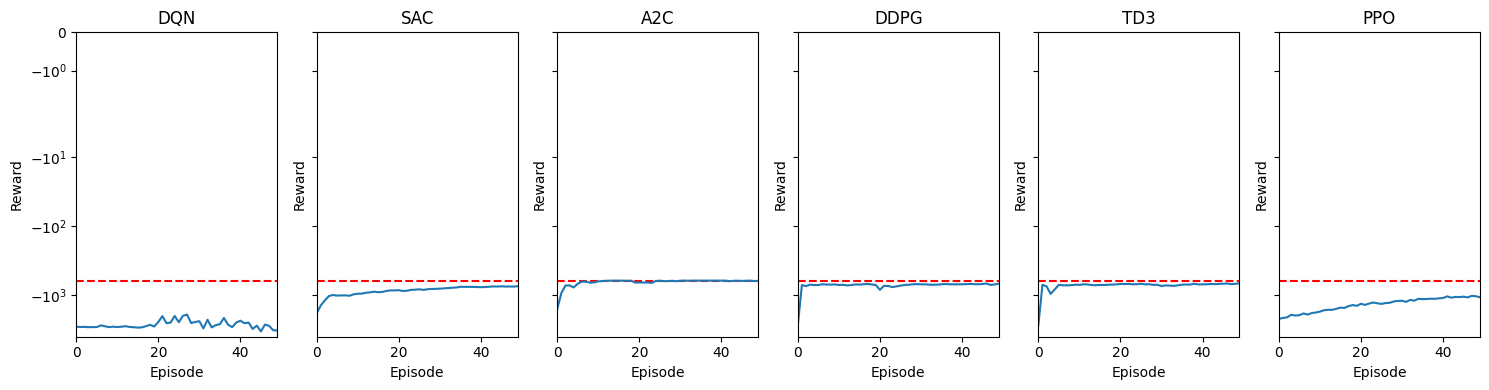

In [36]:
%matplotlib inline

rewards = {
    'DQN': dqn_callback.reward_history[:number_of_episodes],
    'SAC': sac_callback.reward_history[:number_of_episodes],
    'A2C': a2c_callback.reward_history[:number_of_episodes],
    'DDPG': ddpg_callback.reward_history[:number_of_episodes],
    'TD3': td3_callback.reward_history[:number_of_episodes],
    'PPO': ppo_callback.reward_history[:number_of_episodes]
}

min_value = min(min(rewards[key]) for key in rewards)
max_value = max(max(rewards[key]) for key in rewards)

round_factor = 10 ** np.floor(np.log10(max(abs(min_value), abs(max_value))))
min_value = np.floor(min_value / round_factor) * round_factor
max_value = np.ceil(max_value / round_factor) * round_factor

fig, axs = plt.subplots(1, len(rewards), figsize=(15, 4), sharey=True)

rbc_rewards = [episode_reward['sum'][0] for episode_reward in rbc_model.env.episode_rewards]
for ax, (k, v) in zip(fig.axes, rewards.items()):
    ax.plot(rbc_rewards, 'r--', label='RBC')
    ax = plot_rewards(ax, v, k)
    ax.set_ylim(min_value, max_value)
    ax.set_xlim(0, number_of_episodes - 1)
    ax.set_yscale(value='symlog')

plt.tight_layout()
plt.show()

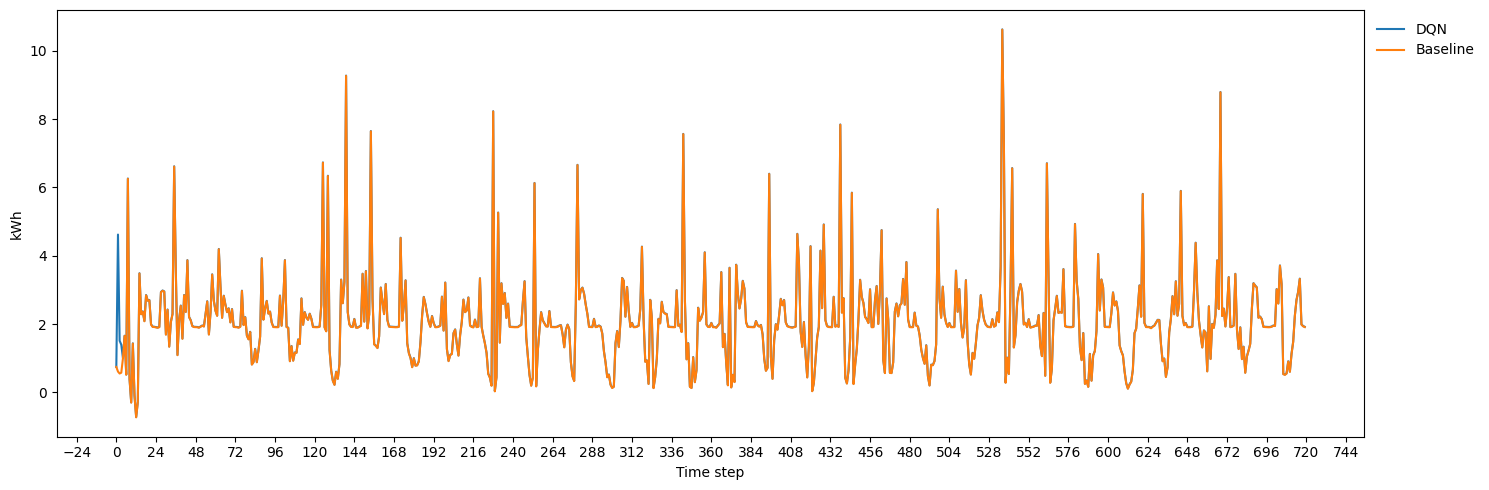

In [47]:
import matplotlib.ticker as ticker

envs = {
    'DQN': dqn_env,
    # 'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label=k)

y = v.net_electricity_consumption_without_storage
ax.plot(x, y, label='Baseline')
ax.set_xlabel('Time step')
ax.set_ylabel('kWh')
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()

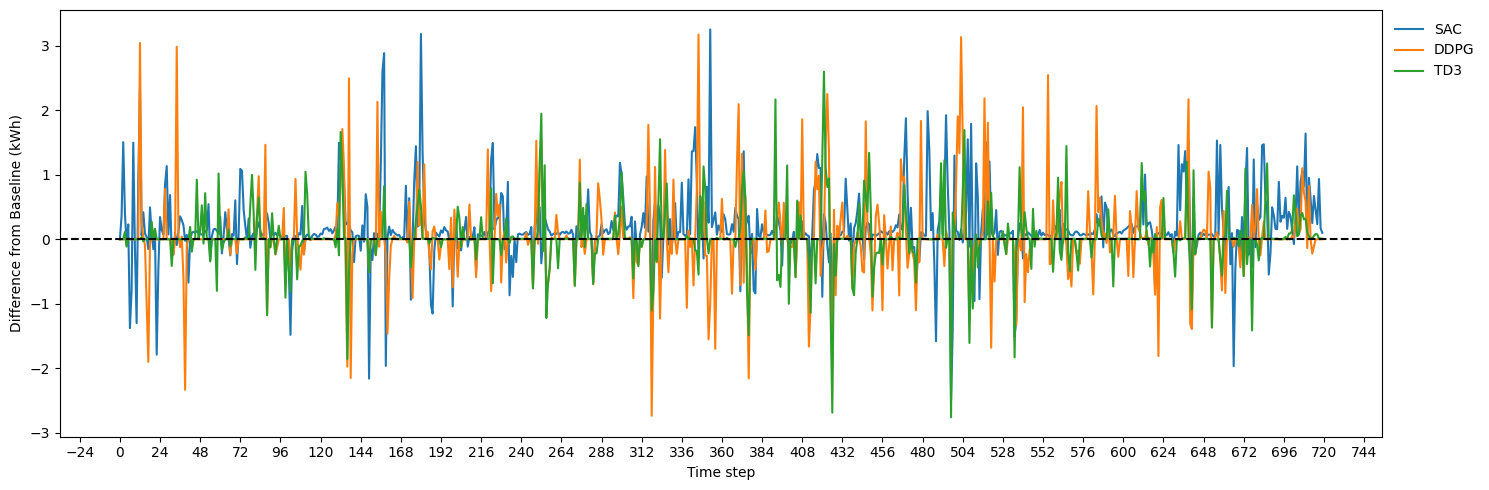

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

envs = {
    # 'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    'DDPG': ddpg_env,
    'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

baseline = ppo_env.net_electricity_consumption_without_storage  # Assuming 'ppo_env' is your baseline environment

for k, v in envs.items():
    y_difference = [y - base for y, base in zip(v.net_electricity_consumption, baseline)]
    x = range(len(y_difference))
    ax.plot(x, y_difference, label=k)

ax.axhline(y=0, color='black', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Time step')
ax.set_ylabel('Difference from Baseline (kWh)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()
plt.show()

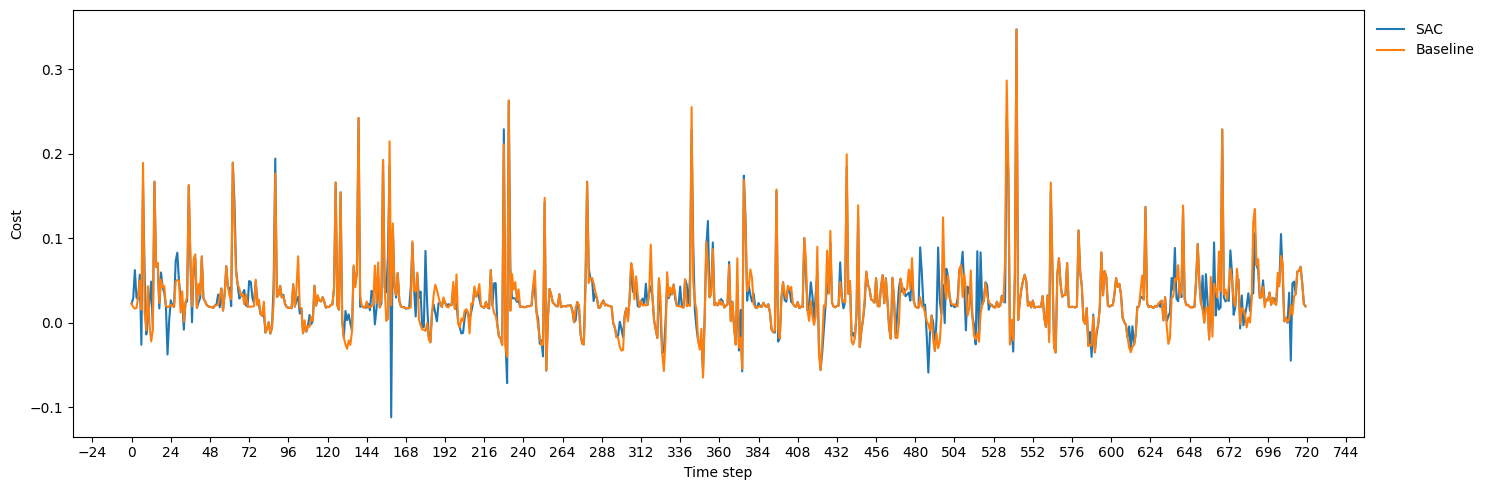

In [39]:
import matplotlib.ticker as ticker

envs = {
    # 'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption_cost
    x = range(len(y))
    ax.plot(x, y, label=k)

y = v.net_electricity_consumption_cost_without_storage
ax.plot(x, y, label='Baseline')
ax.set_xlabel('Time step')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()

In [40]:
import pandas as pd

def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity consumption, cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = [
        'electricity_consumption_total', 'cost_total', 'carbon_emissions_total',
        'daily_peak_average', 'ramping_average', 'monthly_one_minus_load_factor_average'
    ]
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()

    # round up the values to 3 decimal places for readability
    kpis['value'] = kpis['value'].round(3)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis

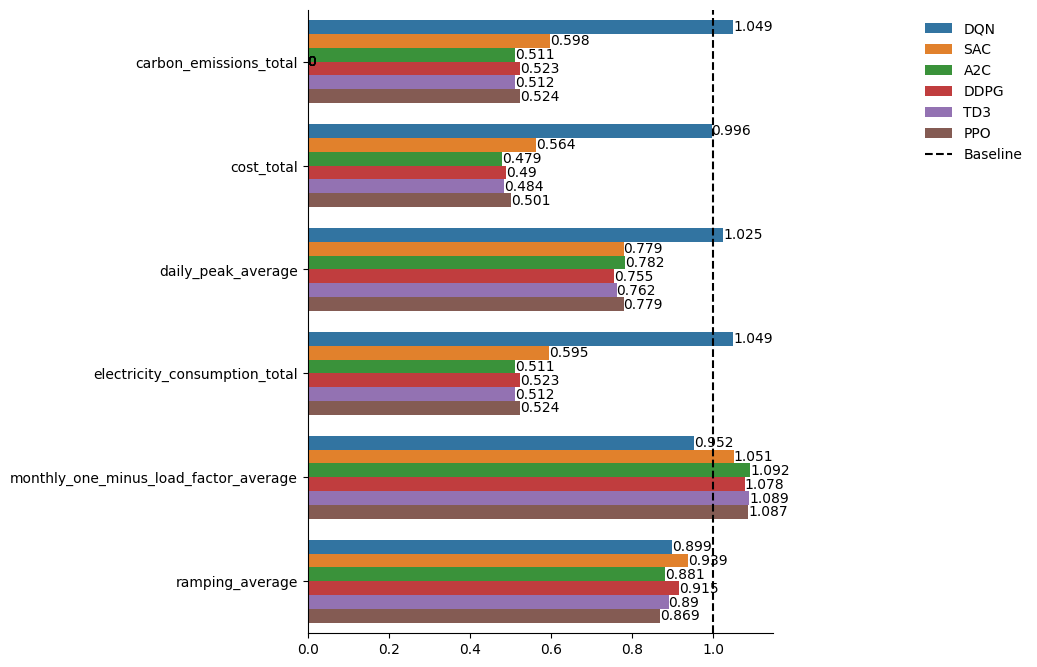

In [41]:
import seaborn as sns

envs = {
    'DQN': dqn_env,
    'SAC': sac_env,
    'A2C': a2c_env,
    'DDPG': ddpg_env,
    'TD3': td3_env,
    'PPO': ppo_env
}

kpis_list = []

for k, v in envs.items():
    kpis = get_kpis(v)
    kpis = kpis[kpis['level']=='district'].copy()
    kpis['env_id'] = k
    kpis_list.append(kpis)

kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
row_count = 1
column_count = 1
env_count = len(envs)
kpi_count = len(kpis['kpi'].unique())
figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
ax.set_xlabel(None)
ax.set_ylabel(None)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width(),
        p.get_y() + p.get_height()/2.0,
        p.get_width(), ha='left', va='center'
    )

ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)

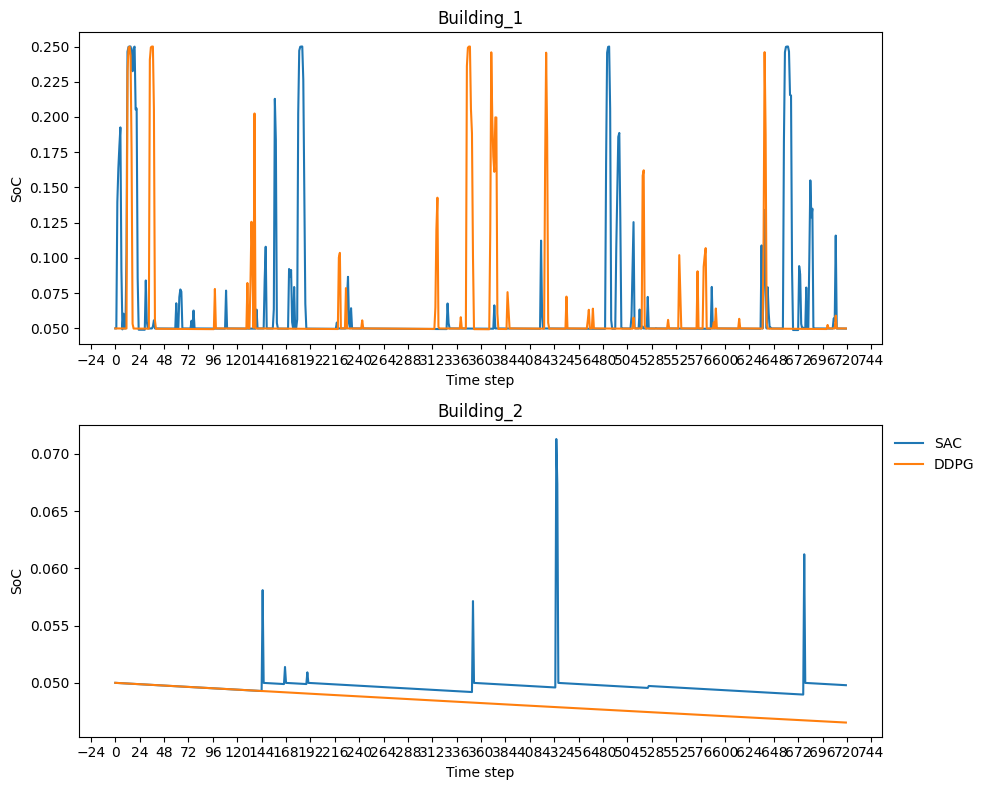

In [42]:
import math

envs = {
    # 'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

building_count = len(list(envs.values())[0].buildings)
column_count_limit = 1
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
figsize = (10.0*column_count, 4*row_count)
fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

for i, ax in enumerate(fig.axes):
    for k, v in envs.items():
        soc = np.array(v.buildings[i].electrical_storage.soc)
        capacity = v.buildings[i].electrical_storage.capacity_history
        y = soc/capacity
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_title(v.buildings[i].name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('SoC')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

    if i == building_count - 1:
        ax.legend(
            loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
        )
    else:
        ax.legend().set_visible(False)


plt.tight_layout()

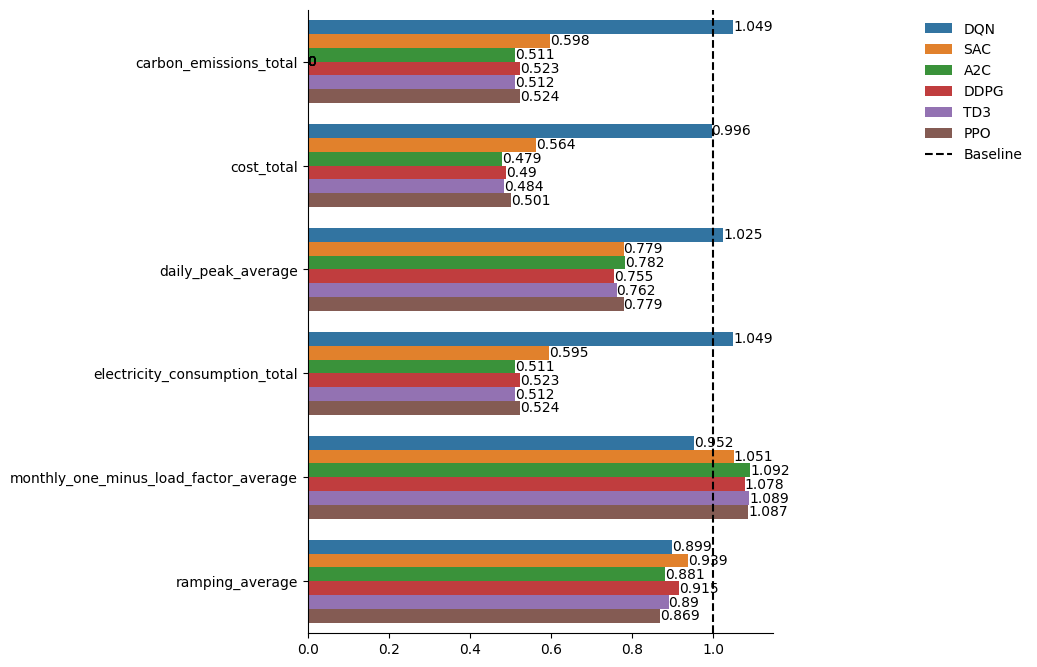

In [43]:
import seaborn as sns

envs = {
    'DQN': dqn_env,
    # 'DQNR': dqnr_env,
    'SAC': sac_env,
    'A2C': a2c_env,
    'DDPG': ddpg_env,
    'TD3': td3_env,
    'PPO': ppo_env,
    # 'SACR': sacr_env
}

kpis_list = []

for k, v in envs.items():
    kpis = get_kpis(v)
    kpis = kpis[kpis['level']=='district'].copy()
    kpis['env_id'] = k
    kpis_list.append(kpis)

kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
row_count = 1
column_count = 1
env_count = len(envs)
kpi_count = len(kpis['kpi'].unique())
figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
ax.set_xlabel(None)
ax.set_ylabel(None)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width(),
        p.get_y() + p.get_height()/2.0,
        p.get_width(), ha='left', va='center'
    )

ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)

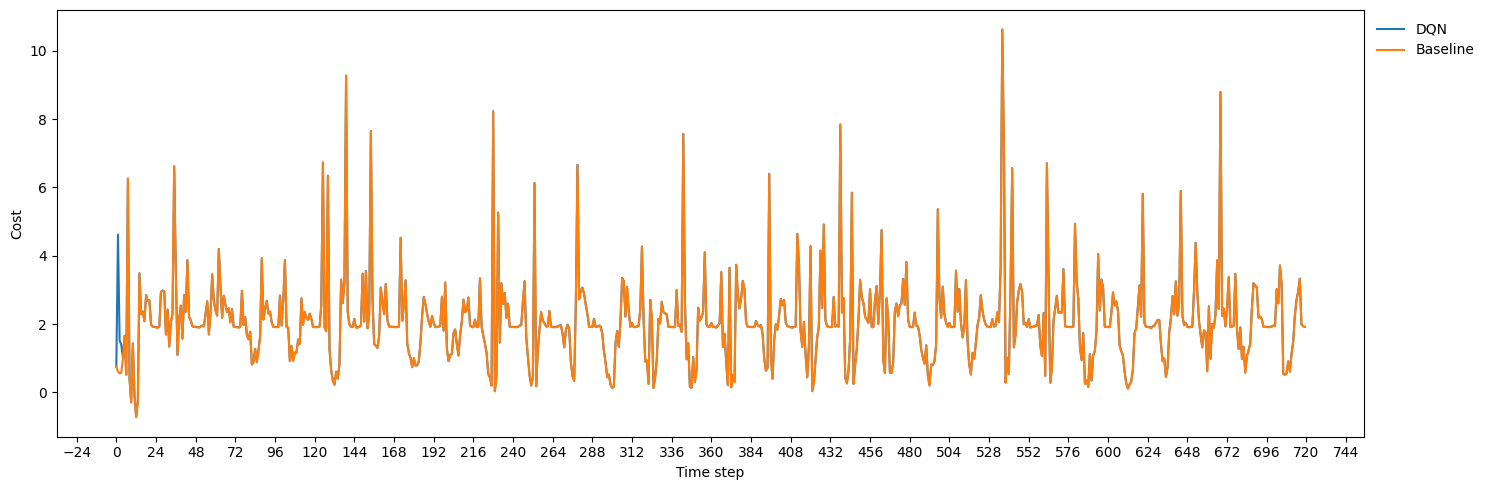

In [44]:
import matplotlib.ticker as ticker

envs = {
    # "DQNR": dqnr_env,
    'DQN': dqn_env,
    # 'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label=k)

y = v.net_electricity_consumption_without_storage
ax.plot(x, y, label='Baseline')
ax.set_xlabel('Time step')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()

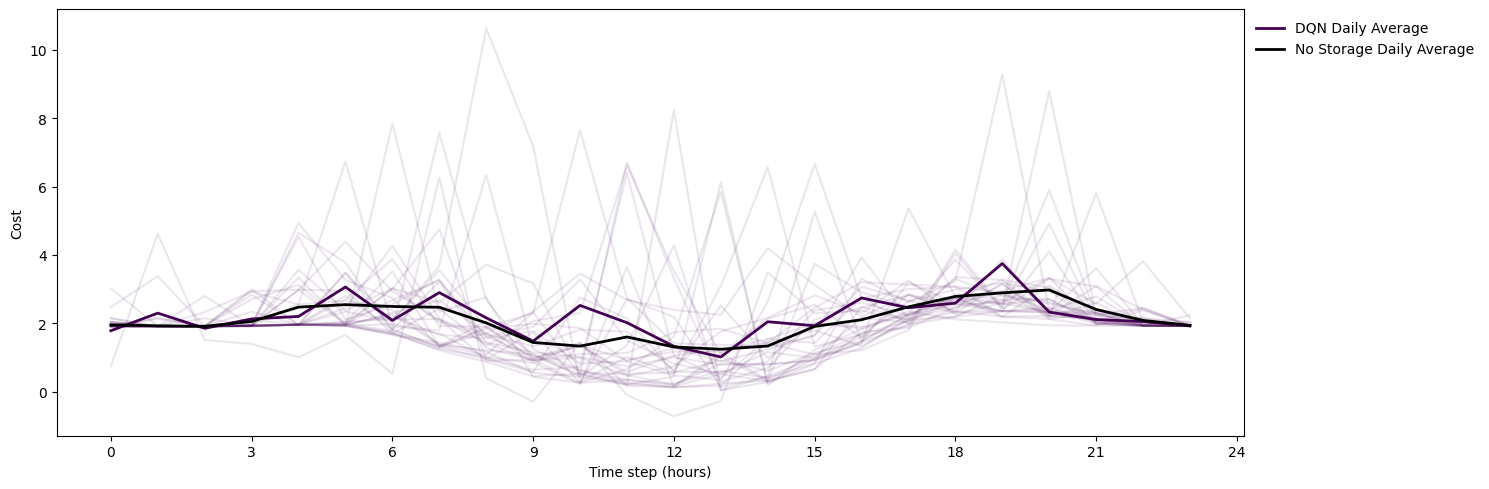

In [45]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

envs = {
    # "Baseline": rbc_env,
    # "DQNR": dqnr_env,
    'DQN': dqn_env,
    # 'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

# Calculate daily averages
daily_averages = np.zeros((len(envs), 24))
for i, (k, v) in enumerate(envs.items()):
    y = v.net_electricity_consumption
    for j in range(7):  # 7 days in a week
        daily_averages[i] += y[j*24:(j+1)*24]
    daily_averages[i] /= 7

x = range(24)  # 24 hours in a day
colors = plt.cm.viridis(np.linspace(0, 1, len(envs)))
# Plot individual daily lines with opacity
for i, (k, v) in enumerate(envs.items()):
    y = v.net_electricity_consumption
    color = colors[i]
    for j in range(30):  # 7 days in a week
        ax.plot(x, y[j*24:(j+1)*24], color=color, alpha=0.1)

# Plot thick average line
for i, (k, v) in enumerate(envs.items()):
    color = colors[i]
    ax.plot(x, daily_averages[i], color=color, label=f'{k} Daily Average', linewidth=2)

# Calculate and plot daily averages for the baseline
y_baseline = v.net_electricity_consumption_without_storage
baseline_daily_average = np.mean(y_baseline.reshape(-1, 24), axis=0)
ax.plot(range(24), baseline_daily_average, label='No Storage Daily Average', color='black', linewidth=2)

ax.set_xlabel('Time step (hours)')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))  # Show ticks every 3 hours
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()
plt.show()

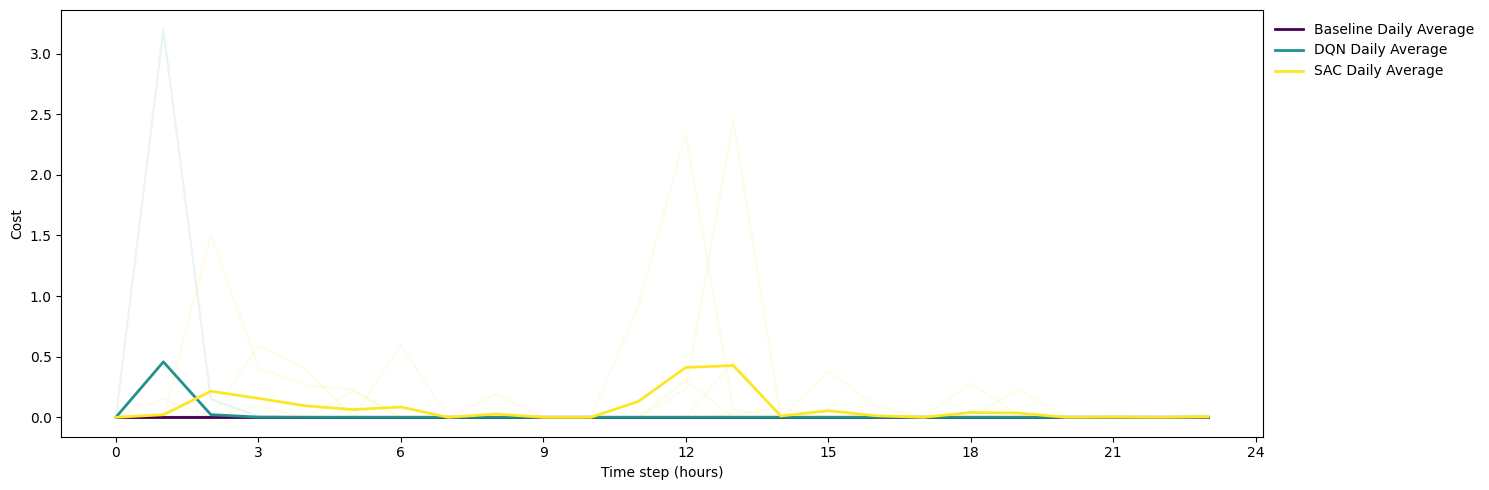

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

envs = {
    "Baseline": rbc_env,
    # "DQNR": dqnr_env,
    'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

# Calculate daily averages
daily_averages = np.zeros((len(envs), 24))
for i, (k, v) in enumerate(envs.items()):
    y = v.energy_to_electrical_storage
    for j in range(7):  # 7 days in a week
        daily_averages[i] += y[j*24:(j+1)*24]
    daily_averages[i] /= 7

x = range(24)  # 24 hours in a day
colors = plt.cm.viridis(np.linspace(0, 1, len(envs)))
# Plot individual daily lines with opacity
for i, (k, v) in enumerate(envs.items()):
    y = v.energy_to_electrical_storage
    color = colors[i]
    for j in range(7):  # 7 days in a week
        ax.plot(x, y[j*24:(j+1)*24], color=color, alpha=0.1)

# Plot thick average line
for i, (k, v) in enumerate(envs.items()):
    color = colors[i]
    ax.plot(x, daily_averages[i], color=color, label=f'{k} Daily Average', linewidth=2)

# Calculate and plot daily averages for the baseline
# y_baseline = v.energy_to_electrical_storage
# baseline_daily_average = np.mean(y_baseline.reshape(-1, 24), axis=0)
# ax.plot(range(24), baseline_daily_average, label='No Storage Daily Average', color='black', linewidth=2)

ax.set_xlabel('Time step (hours)')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))  # Show ticks every 3 hours
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()
plt.show()